Grad-CAM is applied to an Xception model trained to classify skin lesions as either benign or malignant. The overlaid heatmap on the input image highlights the regions that the model considers most indicative of the predicted class, providing valuable insights into the model's decision-making process. This visualization helps clinicians and researchers verify that the model is focusing on relevant features, thus enhancing the model's reliability and usability in real-world scenarios.

Predicted class: Malignant, Probability: 0.9303


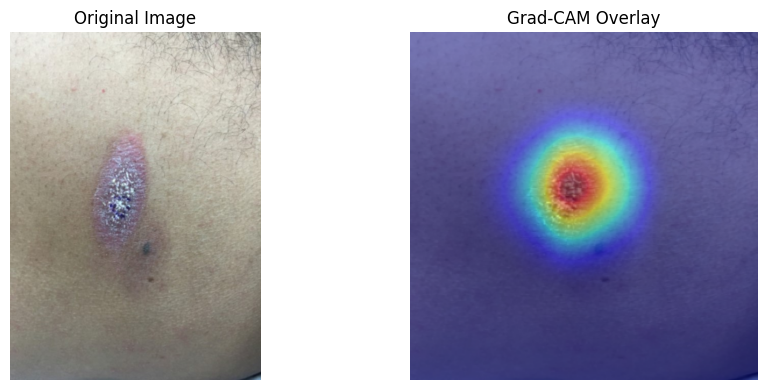

In [4]:
import torch
import timm
from PIL import Image
from torchvision import transforms
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

# Load the trained Xception model
model = timm.create_model('legacy_xception', pretrained=False, num_classes=2)
model.load_state_dict(torch.load('Xception_model.pth'))
model.eval()  # Ensure the model is in evaluation mode

# Identify the target layer for Grad-CAM
target_layer = model.conv4

# Define Grad-CAM method before the forward pass to ensure hooks are set
cam_extractor = GradCAM(model, target_layer)

# Load and preprocess the image
image_path = "D:/BTS Master's/FINAL PROJECT/Data Sets/SKIN DATASETS/TEST/000022.png"
image = Image.open(image_path).convert("RGB")
preprocess = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize to the input size expected by the model
    transforms.ToTensor(),  # Convert the image to a tensor
])
image_tensor = preprocess(image).unsqueeze(0)  # Add a batch dimension

# Forward pass through the model to get the raw output logits
output = model(image_tensor)

# Convert logits to probabilities using softmax
probabilities = torch.nn.functional.softmax(output, dim=1)

# Get the predicted class index
predicted_index = torch.argmax(probabilities, dim=1).item()

# Compute Grad-CAM
cam_list = cam_extractor(predicted_index, output)

# Ensure we received a CAM output and access the first item if the list is not empty
if cam_list:
    cam_tensor = cam_list[0]
else:
    raise ValueError("No CAMs were returned.")

# Overlay CAM on the image
result = overlay_mask(to_pil_image(image_tensor.squeeze()), to_pil_image(cam_tensor, mode='F'), alpha=0.5)

# Display the original image, Grad-CAM overlay, and print the prediction
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis("off")
axes[1].imshow(result)
axes[1].set_title("Grad-CAM Overlay")
axes[1].axis("off")

# Print the prediction
class_names = ['Benign', 'Malignant']  # Example class names
predicted_class = class_names[predicted_index]
predicted_probability = probabilities[0, predicted_index].item()
print(f"Predicted class: {predicted_class}, Probability: {predicted_probability:.4f}")

plt.tight_layout()
plt.show()